# Spatial analysis of kiva loans in Kenya
In this article I demonstrate how to visualize spatial point data using geopandas as folium modules. The points represents the locations of enterprises or businesses that have benefited from kiva loans (https://www.kiva.org/). You access the shapefile of the points from Geospatial Analysis course on kaggle (https://www.kaggle.com/learn/geospatial-analysis). 

While exploring kiva loans data, I notticed that for Kenya, there was a point whole coordinates seems to be falling in India. This motivated me to try and work around this in order to show how such can be rectified and the final data visualized as a heatmap. Enjoy!

# Libraries and data exploration

In [1]:
# Import libraries to wrangle and visualize the data. You can check online on how to install any of them.

import pandas as pd
import geopandas as gpd
import geoplot
import folium
from folium import plugins

In [2]:
# Import the data

kiva_loans = gpd.read_file('kaggle/kiva_loans/kiva_loans/kiva_loans.shp')

<AxesSubplot:>

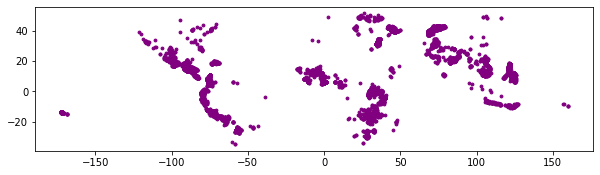

In [3]:
kiva_loans.plot(markersize = 8, figsize = (10, 10), color = 'purple') # All the kiva loans points globally.

In [4]:
len(kiva_loans) # To know the number of records in the dataset (13662 records), pretty average size dataset

13662

In [5]:
# Subset the global dataset for Kenya alone.
kiva_kenya = kiva_loans[kiva_loans.country == 'Kenya']

<AxesSubplot:>

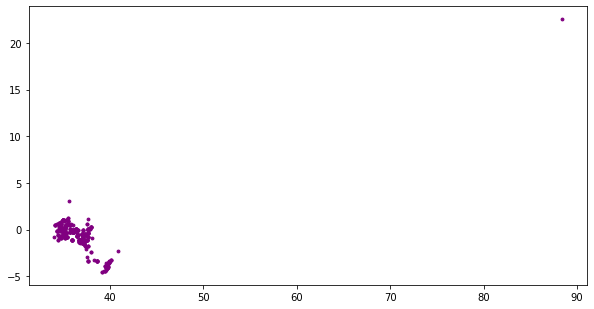

In [6]:
# Let us plot the subset kiva_kenya
kiva_kenya.plot(markersize = 8, figsize = (10, 10), color = 'purple') # There is a point (maybe more) that lie(s) outside the boundaries of Kenya, almost at longitude 90

# The task
The task here is to drop that point and visualize the rest of the data. There are many options to achieve that, for example:

1. One can think of checking through the longitudes values and leave row with value greater than 60 (Kenya does not stretch that far).
2. One may have the boundary map of Kenya and overlay-intersect with the points to leave out those that are outside the polygon.
3. etc

Disclaimer: We do not rule out the possibility that the point still referred to a Kenyan loan. Maybe at the time of  award, India was the location of the business. Other reasons maya also be there to justify the location of the point in India. However, in this case, we will consider it an error and drop it. Well, we would also dig deeper into the data to geolocate it accordingly, but that would mean contacting the data owners for additional information regarding the recipient of the loan. An effort which may not be worth it in this short demonstration.

In [7]:
len(kiva_kenya) # Count number of points/records in the dataset for Kenya.

568

# Map visualization

In order to do this, we will need the map of kenya and look for the maximum longitude value. We will get map of Kenya from GADM

In [8]:
kenya = gpd.read_file('https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_KEN_0.json') 
kenya.bounds.iloc[0,2]

41.9262

Now we know the maximum longitude for Kenya, so we can eliminate all values of longitudes in the dataset that fall beyond that value (41.9262). However, before that, we need to create both longitude and latitude columns in the kiva_kenya dataset. Currently both coordinates are combined in a single column called geometry.

In [9]:
kiva_kenya['latitude'] = kiva_kenya.geometry.map(lambda p: p.y)
kiva_kenya['longitude'] = kiva_kenya.geometry.map(lambda p: p.x)

D:\Anaconda3\envs\kaggle_geo\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
D:\Anaconda3\envs\kaggle_geo\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [10]:
kiva_kenya.head() # Now we have the latitude and longitude columns.

,Partner ID,Field Part,sector,Loan Theme,country,amount,geometry,latitude,longitude
5120,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,600,POINT (34.92034 -0.17444),-0.174439,34.920338
5121,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,1050,POINT (39.61421 -3.99632),-3.996317,39.614209
5122,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,150,POINT (39.61421 -3.99632),-3.996317,39.614209
5123,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,400,POINT (39.61421 -3.99632),-3.996317,39.614209
5124,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,1100,POINT (39.69353 -4.01552),-4.015524,39.693534


In [11]:
kiva_kenya = kiva_kenya[kiva_kenya.longitude < kenya.bounds.iloc[0,2]] # Selecting points where the value of longitude is less than maximum longitude for Kenya.

<AxesSubplot:>

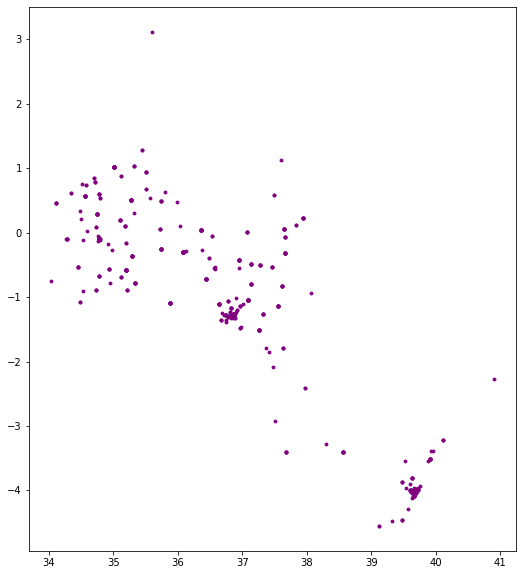

In [12]:
kiva_kenya.plot(markersize = 8, figsize = (10, 10), color = 'purple') # Now this seems promising. The next steo is to plot a map of Kenya and see.

<AxesSubplot:>

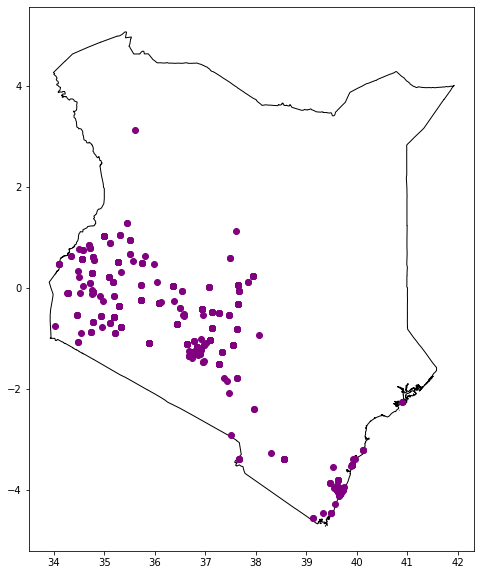

In [13]:
ax = kenya.plot(color = 'none', edgecolor = 'black', figsize = (10, 10), markersize = 8)
kiva_kenya.plot(ax = ax, color = 'purple')

The map we have created above now depicts the right positions of the kivi loan points that are within the maximum longitudinal extent for Kenya. However, the map is quite static, good for publication work but not for interactive display on the web. So we make the next step of the task by creating an interactive map. To do that the points should be in geographic coordinates. So let us check the coordinates of the points data.

In [14]:
kiva_kenya.crs # Nothing returns, meaning it has no crs. Actually, if we check the original files that came with the data, there is no .prj file.
# So, let us assign it the crs of kenya polygon.

In [15]:
kiva_kenya.crs = kenya.crs

In [16]:
kiva_kenya.crs # Now this is pretty fine. The next step is to plot it on top of an openstreetmap using folium.

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
kiva_kenya

,Partner ID,Field Part,sector,Loan Theme,country,amount,geometry,latitude,longitude
5120,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,600,POINT (34.92034 -0.17444),-0.174439,34.920338
5121,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,1050,POINT (39.61421 -3.99632),-3.996317,39.614209
5122,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,150,POINT (39.61421 -3.99632),-3.996317,39.614209
5123,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,400,POINT (39.61421 -3.99632),-3.996317,39.614209
5124,133,VisionFund Kenya,General Financial Inclusion,General,Kenya,1100,POINT (39.69353 -4.01552),-4.015524,39.693534
...,...,...,...,...,...,...,...,...,...
13593,512,"N/A, direct to EcoZoom",DSE Direct,SME,Kenya,50000,POINT (36.82195 -1.29207),-1.292066,36.821946
13600,520,"N/A, direct to Moko Furniture (Watervale Inves...",DSE Direct,Micro-enterprise,Kenya,50000,POINT (36.82195 -1.29207),-1.292066,36.821946
13605,526,"N/A, direct to Pawame",DSE Direct,Solar Home Systems,Kenya,50000,POINT (36.82195 -1.29207),-1.292066,36.821946
13641,529,"N/A, direct to LLK",DSE Direct,SME,Kenya,36000,POINT (36.83041 -1.17481),-1.174810,36.830410


In [18]:
m = folium.Map(location = [kiva_kenya['latitude'].mean(), kiva_kenya['longitude'].mean()], zoom_start=6)

folium.Choropleth(
   geo_data = kiva_kenya,
).add_to(m) 

#folium.Popup(html = kiva_kenya.amount).add_to(m)

m
# The plotted map can be zoomed and panned around.

That is now more appealing than the static map. However, as we can see some points are quite close together, we can go ahead and generate a heatmap to represent the points better.

In [19]:
m = folium.Map(location=[0, 39], zoom_start=6)
kenya_mat = kiva_kenya
kenya_mat = pd.DataFrame(kenya_mat)
kenya_mat = kenya_mat[['latitude', 'longitude']].values

# plot heatmap
m.add_children(plugins.HeatMap(kenya_mat, radius=15))
m

C:\Windows\Temp\ipykernel_2212\2378177092.py:7: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(plugins.HeatMap(kenya_mat, radius=15))


If necessary, we cana also add the layer of Kenya we had to hep in knowing which points fell within the country while zooming in.

In [20]:
m = folium.Map(location=[0, 39], zoom_start=6)
folium.GeoJson(
    kenya,
    style_function=lambda feature: {
        "fillColor": "none",#ffff00
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },
).add_to(m)
kenya_mat = kiva_kenya
kenya_mat = pd.DataFrame(kenya_mat)
kenya_mat = kenya_mat[['latitude', 'longitude']].values

# plot heatmap
m.add_children(plugins.HeatMap(kenya_mat, radius=15))
m

C:\Windows\Temp\ipykernel_2212\142631498.py:16: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(plugins.HeatMap(kenya_mat, radius=15))


We can also have the Kenyan map shaded with some light color to show its regional expanse.

In [21]:
m = folium.Map(location=[0, 39], zoom_start=6)
folium.GeoJson(
    kenya,
    style_function=lambda feature: {
        "fillColor": "purple",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },
).add_to(m)
kenya_mat = kiva_kenya
kenya_mat = pd.DataFrame(kenya_mat)
kenya_mat = kenya_mat[['latitude', 'longitude']].values

# plot heatmap
m.add_children(plugins.HeatMap(kenya_mat, radius=15))
m

C:\Windows\Temp\ipykernel_2212\2144662319.py:16: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(plugins.HeatMap(kenya_mat, radius=15))


# Conclusion

Clearly, distribution of Kiva loans in Kenya is not uniform. The spread depicts the distribution of major urban centers in the country, concentrating in western, central, and coast. Both coastal and central regions tend to have the highest concentrations of funding by kiva. They are closely followed by the western region. Northern and northwestern regions of the country are largely not funded/underfunded by kiva. These are the regions which typically need these kinds of humanitarian assistance. It would be great to enhance awareness about the funds to the people within the underfunded regions. This will help them to raise their income and boost livelihood. Better still, applicants from such regions should be motivated to take the loans by lowering interest rates for them and lengthening their repayment periods.